# Get a raw image, display it and superimpose the position of the reference sources

In [1]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display.ds9 as ds9
import numpy

butler = dafPersist.Butler("/sps/lsst/dataproducts/desc/DC2/Run1.2p/w_2018_18/data/input")
#butler = dafPersist.Butler("/sps/lsst/users/lsstprod/desc/DC2-test/input")
dataid = {'visit':159480, 'raft':'3,2', 'sensor':'2,1'}

raw = butler.get('eimage', dataid)
wcsRaw = raw.getWcs()

In [7]:
# Display image in ds9 (the display_ds9 stack package should be set up)
ds9.mtv(raw.getMaskedImage().getImage(),frame=1,wcs=wcsRaw)

## Create and load a catalog with reference objects 

In [30]:
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask

# Configure LoadIndexedReferenceObjectsTask
refConfig = LoadIndexedReferenceObjectsTask.ConfigClass()
refConfig.ref_dataset_name = 'cal_ref_cat'
refTask = LoadIndexedReferenceObjectsTask(butler, config=refConfig)

#define a reference filter (not critical for what we are doing) 
filter = 'lsst_g_smeared'

# Find the approximate celestial coordinates of the sensor's center 
centerPixel = afwGeom.Point2D(2000., 2000.)
centerCoord = wcsRaw.pixelToSky(centerPixel)

# Retrieve reference object within a 0.5 deg radius circle around the sensor's center
radius = afwGeom.Angle(0.5, afwGeom.degrees)
ref = refTask.loadSkyCircle(centerCoord, radius, filter).refCat.copy(deep=True)

In [23]:
# We can now display the reference catalog as an astropy table
ref.asAstropy()

id,coord_ra,coord_dec,parent,lsst_u_smeared_flux,lsst_g_smeared_flux,lsst_r_smeared_flux,lsst_i_smeared_flux,lsst_z_smeared_flux,lsst_y_smeared_flux,lsst_u_smeared_fluxSigma,lsst_g_smeared_fluxSigma,lsst_r_smeared_fluxSigma,lsst_i_smeared_fluxSigma,lsst_z_smeared_fluxSigma,lsst_y_smeared_fluxSigma,resolved,variable,raJ2000,decJ2000,sigma_raJ2000,sigma_decJ2000,lsst_u,lsst_g,lsst_r,lsst_i,lsst_z,lsst_y,properMotionRa,properMotionDec,parallax,radialVelocity,centroid_x,centroid_y,hasCentroid
,rad,rad,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
1472569666564,0.9336569089020001,-0.5013848915899238,-1,0.0002811490477613752,0.0009521194935184681,0.0015249058022556179,0.0018226523879508428,0.0019478023475058305,0.002016877016274279,2.5894784251392547e-07,8.769344610098664e-07,1.4044901473975649e-06,1.6787248872822446e-06,1.7939922597862936e-06,1.857612380830186e-06,False,False,53.4946004,-28.7272382,2.777777778e-08,2.777777778e-08,17.7783003,16.45342374,15.94260444,15.74943099,15.67683222,15.6386142,0.0,0.0,0.0,0.0,nan,nan,False
1606094014468,0.9335128618975587,-0.5014628224280934,-1,3.014354050122017e-06,7.130187671133666e-06,9.904422838275282e-06,1.113821859385684e-05,1.1488289866129806e-05,1.158971106251927e-05,2.7763226803268738e-09,6.567145536720925e-09,9.122310552848977e-09,1.0258678438689545e-08,1.0581105995898023e-08,1.0674518369866024e-08,False,False,53.486347099999996,-28.731703299999996,2.777777778e-08,2.777777778e-08,22.7030421,21.76838467,21.40940485,21.28166316,21.24873626,21.23854415,0.0,0.0,0.0,0.0,nan,nan,False
1606085762052,0.9333080736002799,-0.5009947024487498,-1,8.850692431010531e-07,2.045019986869441e-06,2.8851116797259816e-06,3.26447414214073e-06,3.368353357363083e-06,3.4106767830686583e-06,8.151788981728033e-10,1.883533014656182e-09,2.657286058144023e-09,3.0066917984631086e-09,3.1023680914402727e-09,3.1413494070859124e-09,False,False,53.4746136,-28.704882,2.777777778e-08,2.777777778e-08,24.03359046,23.12513149,22.75120131,22.61574991,22.57934975,22.56836064,0.0,0.0,0.0,0.0,nan,nan,False
1704412297220,0.9329869211634945,-0.5016908530421941,-1,2.643354711124466e-07,1.9032270471142927e-06,4.827389627196922e-06,7.190616201008295e-06,8.62089971184688e-06,9.50595156014846e-06,2.4346196613323115e-10,1.7529368909073788e-09,4.446190157463087e-09,6.6228022695532715e-09,7.940142065878117e-09,8.755304942848536e-09,False,False,53.4562129,-28.7447685,2.777777778e-08,2.777777778e-08,25.34489836,23.20215765,22.19136385,21.75832868,21.56319307,21.45490183,0.0,0.0,0.0,0.0,nan,nan,False
1606090416132,0.932991378300543,-0.5013077934777403,-1,1.8958023658810302e-06,5.845568430694717e-06,9.306550898984725e-06,1.0976002389584293e-05,1.1643738972018668e-05,1.205142207416816e-05,1.7460985067762019e-09,5.383967491437703e-09,8.571650146877027e-09,1.0109271793169528e-08,1.0724279913473601e-08,1.1099769926943597e-08,False,False,53.45646829999999,-28.722820799999997,2.777777778e-08,2.777777778e-08,23.20574475,21.98220615,21.48091054,21.29760746,21.23460478,21.1985754,0.0,0.0,0.0,0.0,nan,nan,False
1606090471428,0.9333133908633792,-0.5012745924630857,-1,3.610382013496806e-06,7.193044795262797e-06,9.2670166840656e-06,1.0084005942009434e-05,1.0189525978930632e-05,1.0113365077540496e-05,3.32528472171663e-09,6.6250390875242095e-09,8.535237789302627e-09,9.287712703893722e-09,9.384900249504495e-09,9.314753467020528e-09,False,False,53.47491829999999,-28.7209185,2.777777778e-08,2.777777778e-08,22.50735272,21.75748213,21.48184479,21.39140069,21.3803171,21.38802438,0.0,0.0,0.0,0.0,nan,nan,False
1606091138052,0.9332862668698001,-0.5013200041548598,-1,2.5016011328945126e-05,5.2134408304520246e-05,6.917337616187598e-05,7.629458251745932e-05,7.806512813890234e-05,7.792944672848751e-05,2.3040597908879688e-0

## Display the bright reference sources as a small circle overlaid on the ds9 image

In [10]:
for r in ref:
    ra = r.get("coord_ra")
    dec = r.get("coord_dec")
    mag = r.get("lsst_z")
    c = afwGeom.SpherePoint(ra, dec)
    pt = wcsRaw.skyToPixel(c)
    # Ignore sources which lye outside the sensor footprint or which are too faint 
    if (pt.getX() > 4000) or (pt.getX()<0) or (pt.getY()>4000) or (pt.getY()<0) or mag > 21:
        continue
    with ds9.Buffering():
        ds9.dot('o', pt.getX(), pt.getY(), frame=1, size=8)

### Note that reference sources does not exactly match the sources in the raw images according to Scott 
### this is due to the fact that PhoSim  does not include an internal model for the motion of the earth

## We can now redo the same thing with the calibrated exposure (calexp)

In [ ]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display.ds9 as ds9
import numpy

# We need to get a new butler as calexp are in the output directory while eImage(raw) was in the input

butler = dafPersist.Butler("/sps/lsst/dataproducts/desc/DC2/Run1.2p/w_2018_18/data/output")
#butler = dafPersist.Butler("/sps/lsst/users/lsstprod/desc/DC2-test/output")
calexp = butler.get('calexp', dataid)
wcs = calexp.getWcs()

# display in another frame
ds9.mtv(calexp.getMaskedImage().getImage(),frame=2,wcs=wcs)

In [26]:
import lsst.afw.geom as afwGeom
meta = butler.get('calexp_md', dataid)
wcs = afwGeom.makeSkyWcs(meta)
bbox = butler.get('calexp_bbox', dataid)
butler.getKeys()

AttributeError: 'NoneType' object has no attribute 'find'

In [32]:
for r in ref:
    ra = r.get("coord_ra")
    dec = r.get("coord_dec")
    mag = r.get("lsst_z")
    c = afwGeom.SpherePoint(ra, dec)
    pt = wcs.skyToPixel(c)
    # Ignore sources which lie outside the sensor footprint or which are too faint 
    if (pt.getX() > 4000) or (pt.getX()<0) or (pt.getY()>4000) or (pt.getY()<0) or mag > 21:
        continue
    with ds9.Buffering():
        ds9.dot('o', pt.getX(), pt.getY(), frame=2, size=8)

In [17]:
ra = []
dec = []
for r in ref:
    mag = r.get("lsst_z")
#    c = afwCoord.IcrsCoord(ra, dec)
#    pt = wcsRaw.skyToPixel(c)
    if mag > 21:
        continue
    ra.append(afwGeom.radToDeg(r.get("coord_ra")))
    dec.append(afwGeom.radToDeg(r.get("coord_dec")))

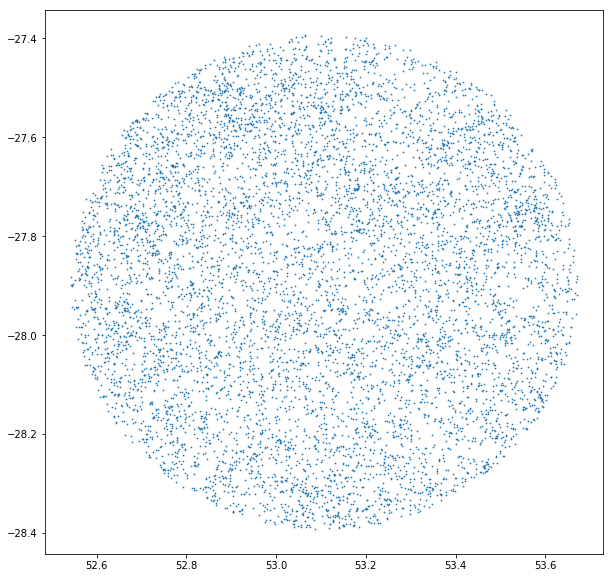

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

fig, (ax0) = plt.subplots(ncols=1, figsize=(10, 10))
_ = ax0.scatter(ra, dec, s=0.5)

In [15]:
ref['id']%1024

array([  4,   4,   4, ..., 231, 231, 231])

In [19]:
srcA = butler.get('src', dataid).asAstropy()
refA = ref.asAstropy()

In [22]:
fluxType = "base_CircularApertureFlux_6_0"

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         fluxType + "_flag", "base_SdssCentroid_flag", 
         "base_SdssCentroid_flag_almostNoSecondDerivative", "base_SdssCentroid_flag_edge", "base_SdssCentroid_flag_noSecondDerivative",
         "base_SdssCentroid_flag_notAtMaximum", "base_SdssCentroid_flag_resetToPeak", 
         "base_SdssShape_flag", "base_ClassificationExtendedness_flag"]

# select sources
cut = np.ones_like(srcA['id'], dtype=bool)
for flag in Flags:
    cut &= srcA[flag]==False
cut &= (srcA[fluxType + '_flux'] > 0) & (srcA[fluxType + '_flux'] / srcA[fluxType + '_fluxSigma'] > 5)
#cut &= srcA['base_ClassificationExtendedness_value'] < 0.5

cat = srcA[cut]['id', 'coord_ra', 'coord_dec']

/sps/lsst/software/lsst_distrib/w_2018_14/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


In [42]:
from astropy.coordinates import SkyCoord
from astropy import units as u

cut1 = (refA['id']%1024 == 231)
cut2 = (refA['id']%1024 == 4)

cRef = SkyCoord(ra = refA['coord_ra'], dec = refA['coord_dec'])
cRef1 = SkyCoord(ra = refA[cut1]['coord_ra'], dec = refA[cut1]['coord_dec'])
cRef2 = SkyCoord(ra = refA[cut2]['coord_ra'], dec = refA[cut2]['coord_dec'])
cCat = SkyCoord(ra = cat['coord_ra'], dec = cat['coord_dec'])

In [43]:
idx, d2d, d3d = cCat.match_to_catalog_sky(cRef)
idx1, d2d1, d3d1 = cCat.match_to_catalog_sky(cRef1)
idx2, d2d2, d3d2 = cCat.match_to_catalog_sky(cRef2)

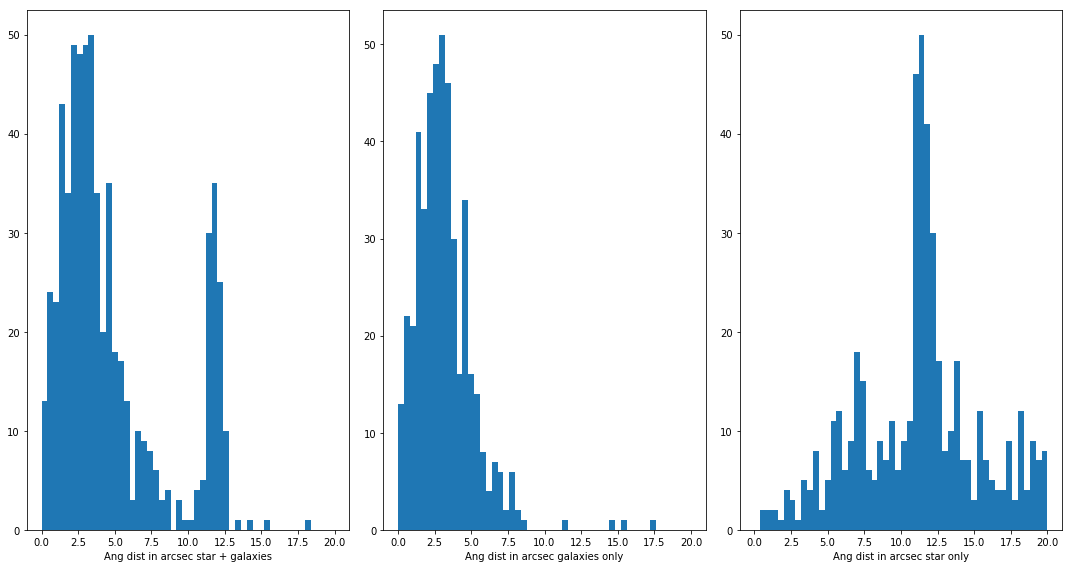

In [53]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8))
_ = ax0.hist(d2d.arcsec, bins=50, range=[0, 20])
_ = ax1.hist(d2d1.arcsec, bins=50, range=[0,20])
_ = ax2.hist(d2d2.arcsec, bins=50, range=[0,20])
ax0.set_xlabel('Ang dist in arcsec star + galaxies')
ax1.set_xlabel('Ang dist in arcsec galaxies only')
ax2.set_xlabel('Ang dist in arcsec star only')
fig.tight_layout()

In [47]:
fig.savefig("refCat.png")

In [51]:
d2d.arcsec

array([ 5.60131805, 12.30680768,  7.33719121, 12.1697606 ,  8.42606095,
        3.28206208, 12.39825475, 11.11489999,  3.74283173, 12.53752201,
       11.79728206, 12.26163615, 12.46428174,  7.98260392, 12.49621931,
       12.4127862 , 10.91585705, 12.08355079, 12.61997687, 12.45318574,
       11.95678513, 12.25223046, 12.5748282 , 12.12384708,  5.41746848,
       12.17893533, 12.42691778, 12.49456306, 12.1121032 , 12.28102879,
        9.40119926,  5.82991214, 12.32984944, 11.75334933,  4.40350168,
       10.76454117, 11.98911167, 12.18948314,  4.94995781, 12.13674178,
       11.52173183,  7.38773099,  5.97635157,  6.79741008, 11.87892917,
       12.33712845,  1.8768769 , 11.75599971,  8.43721   , 12.11424258,
       11.73515168,  5.99829512, 11.70509876, 12.29873855,  9.53477624,
        6.7030128 , 12.13602324, 12.01929928,  2.37315284, 11.8126877 ,
        1.27498747, 12.01913686, 10.4355515 , 12.0356047 ,  9.79022457,
       12.19954259,  5.03725191, 12.08017309,  7.13015573, 11.52